In [8]:
import numpy as np
from typing import List
import src.distribution as dist
import matplotlib.pyplot as plt


class YearResult:
    def __init__(
            self,
            kg_biomass_per_tree: np.ndarray,
            kg_biomass_per_ha: np.ndarray,
            kg_c_per_ha: np.ndarray,
            kg_co2e_per_ha: np.ndarray
    ) -> None:
        self.kg_biomass_per_tree=kg_biomass_per_tree
        self.kg_biomass_per_ha=kg_biomass_per_ha
        self.kg_c_per_ha=kg_c_per_ha
        self.kg_co2e_per_ha=kg_co2e_per_ha

    def plot_histogram(self, result_key: str = "kg_co2e_per_ha") -> None:
        match result_key:
            case "kg_biomass_per_tree":
                array=self.kg_biomass_per_tree
                xlab="$Biomass\u00a0tree^{-1} (kg)$"
            case "kg_biomass_per_ha":
                array=self.kg_biomass_per_ha
                xlab="$Biomass\u00a0ha^{-1} (kg)$"
            case "kg_c_per_ha":
                array=self.kg_c_per_ha
                xlab="$C\u00a0ha^{-1} (kg)$"
            case "kg_co2e_per_ha":
                array=self.kg_co2e_per_ha
                xlab="$CO_2e\u00a0ha^{-1} (kg)$"
        plt.hist(x=array, bins=25)
        plt.xlabel(xlab)
        


class SeriesResults:
    def __init__(self) -> None:
        year_results: List[YearResult] = []

    def yoy_change():
        pass

    def plot():
        pass


class Trees:
    def __init__(
            self,
            trees_ha: dist.Distribution,
            dbh: dist.Distribution,
            c_content: dist.Distribution
    ) -> None:
        self.trees_ha = trees_ha
        self.dbh = dbh
        self.c_content = c_content
        self.r2: np.ndarray
        self.n: np.ndarray

    @staticmethod
    def _calc_kg_biomass_per_tree_mean(dbh: np.ndarray) -> np.ndarray:
        pass

    @staticmethod
    def calc_kg_biomass_per_tree_se(
            r2: np.ndarray,
            n: np.ndarray,
            kg_biomass_per_tree_mean: np.ndarray
    ) -> np.ndarray:
        # return np.sqrt(((1 - r2) / r2 * kg_biomass_per_tree_mean) / np.sqrt(n - 2))
        return kg_biomass_per_tree_mean * np.sqrt(((1 / r2) - 1) / (n - 2))

    @staticmethod
    def calc_kg_biomass_per_tree_sd(
            n: np.ndarray,
            kg_biomass_per_tree_se: np.ndarray
    ) -> np.ndarray:
        return kg_biomass_per_tree_se * np.sqrt(n)

    @staticmethod
    def calc_kg_biomass_per_ha(
            kg_biomass_per_tree: np.ndarray,
            trees_ha: np.ndarray
    ) -> np.ndarray:
        return kg_biomass_per_tree * trees_ha

    @staticmethod
    def calc_kg_c_per_ha(
            kg_biomass_per_ha: np.ndarray,
            c_content: np.ndarray
    ) -> np.ndarray:
        return kg_biomass_per_ha * c_content

    @staticmethod
    def calc_kg_co2e_per_ha(kg_c_per_ha: np.ndarray) -> np.ndarray:
        return np.array([(44/12)]) * kg_c_per_ha

    def calc(self, iterations: int) -> YearResult:
        trees_ha = self.trees_ha.sample(
            shape=(1, iterations),
            column_wise_sampling=False
        ).flatten() # Flatten sampled array from [1, iterations] (2D) to [iterations] (1D)
        dbh = self.dbh.sample(
            shape=(1, iterations),
            column_wise_sampling=False
        ).flatten()
        c_content = self.c_content.sample(
            shape=(1, iterations),
            column_wise_sampling=False
        ).flatten()
        kg_biomass_per_tree_mean = self._calc_kg_biomass_per_tree_mean(dbh=dbh)
        kg_biomass_per_tree_se = self.calc_kg_biomass_per_tree_se(
            r2=self.r2,
            n=self.n,
            kg_biomass_per_tree_mean=kg_biomass_per_tree_mean
        )
        kg_biomass_per_tree_sd = self.calc_kg_biomass_per_tree_sd(
            n=self.n,
            kg_biomass_per_tree_se=kg_biomass_per_tree_se
        )
        kg_biomass_per_tree_dist = dist.TruncatedNormal(
            mu=kg_biomass_per_tree_mean,
            sigma=kg_biomass_per_tree_sd,
            low=np.array([0]),
            high=np.array([np.inf])
        )
        kg_biomass_per_tree = kg_biomass_per_tree_dist.sample(
            shape=(1,iterations),
            column_wise_sampling=False
        ).flatten()
        kg_biomass_per_ha = self.calc_kg_biomass_per_ha(
            kg_biomass_per_tree=kg_biomass_per_tree,
            trees_ha=trees_ha
        )
        kg_c_per_ha = self.calc_kg_c_per_ha(
            kg_biomass_per_ha=kg_biomass_per_ha,
            c_content=c_content
        )
        kg_co2e_per_ha = self.calc_kg_co2e_per_ha(kg_c_per_ha=kg_c_per_ha)
        return YearResult(
            kg_biomass_per_tree=kg_biomass_per_tree,
            kg_biomass_per_ha=kg_biomass_per_ha,
            kg_c_per_ha=kg_c_per_ha,
            kg_co2e_per_ha=kg_co2e_per_ha
        )


class TropicalMoistHardwoods(Trees):
    def __init__(self, trees_ha: np.ndarray, dbh: np.ndarray, c_content: np.ndarray) -> None:
        super().__init__(trees_ha, dbh, c_content)
        self.r2 = 0.98
        self.n = 226

    @staticmethod
    def _calc_kg_biomass_per_tree_mean(dbh: np.ndarray) -> np.ndarray:
        return np.exp(-2.289 + 2.659 * np.log(dbh) - 0.021 * (np.log(dbh))**2)


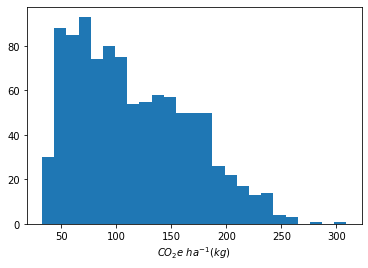

In [11]:
iterations = 1000
trees_ha = dist.DiscreteUniform(low=1, high=1)
dbh = dist.DiscreteUniform(low=8, high=15)
c_content = dist.DiscreteUniform(low=0.45, high=0.55)

tmh = TropicalMoistHardwoods(
    trees_ha=trees_ha,
    dbh=dbh,
    c_content=c_content
)
tmh = tmh.calc(iterations=iterations)
tmh.plot_histogram(result_key="kg_co2e_per_ha")

In [ ]:
# User inputs
tree_type: str = "TropicalMoistHardwoods"
prev_tree_density: int = 1000
prev_tree_density_est: bool = False
prev_dbh_min: float = 5
prev_dbh_avg: float = 10
prev_dbh_max: float = 15
curr_dbh_min: float = 6
curr_dbh_avg: float = 11
curr_dbh_max: float = 16
trees_planted_or_lost: int = 10
trees_planted_or_lost_est: bool = True
area = 1

# Model values
estimate_fraction_plus_minus = 0.1

# Calculate trees_ha distrubution
if prev_tree_density_est:
    lower = prev_tree_density - (estimate_fraction_plus_minus * prev_tree_density)
    upper = prev_tree_density + (estimate_fraction_plus_minus * prev_tree_density)
    prev_tree_density_dist = dist.DiscreteUniform(low=lower, high=upper)
else:
    prev_tree_density_dist = dist.DiscreteUniform(low=prev_tree_density, high=prev_tree_density)

# Calculate dbh distribution
prev_dbh_dist = dist.Triangular(low=prev_dbh_min, mode=prev_dbh_avg, high=prev_dbh_max)
curr_dbh_dist = dist.Triangular(low=curr_dbh_min, mode=curr_dbh_avg, high=curr_dbh_max)

# Calculate trees distribution
if trees_planted_or_lost_est:
    lower = trees_planted_or_lost - (estimate_fraction_plus_minus * trees_planted_or_lost)
    upper = trees_planted_or_lost + (estimate_fraction_plus_minus * trees_planted_or_lost)
    trees_planted_or_lost_dist = dist.DiscreteUniform(low=lower, high=upper)
else:
    trees_planted_or_lost_dist = dist.DiscreteUniform(low=trees_planted_or_lost, high=trees_planted_or_lost)

trees_ha_list = prev_tree_density_dist.sample() + trees_planted_or_lost_dist.sample()
trees_ha_dist = dist.DiscreteUniform(low=min(trees_ha_list), high=max(trees_ha_list))

# Define carbon content distrubtion
c_content = dist.DiscreteUniform(low=0.45, high=0.55)

In [10]:
#TODO: Check SE-SD calculation - is the assumption about the (normal) distribution of the mean correct?
#TODO: Ask for Year 1 and Year 2 input values and calculate diff in each MC iteration
